# 第４章

## 時系列パターン認識の基礎問題

いろいろな時系列パターン認識に関する問題を解いていく。  

In [44]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from reservoir_network.network import EchoStateNetwork
from reservoir_network.train import train_network

%matplotlib inline

## 1 時間的排他的論理和(XOR)タスク

$$
d(n) = XOR(u(n-1), u(n-2)) (n \leq 3)
$$

In [31]:
def xor(u_0, u_1):
    """XOR関数"""
    if u_0 == u_1:
        return 0
    else:
        return 1


In [32]:
d_hidden = 40
network_config = {
    "d_in": 1,
    "d_hidden": d_hidden,
    "d_out": 1,
    "density": 0.1,
    "rho_w": 0.90
}

network = EchoStateNetwork(**network_config)

In [33]:
num_steps = 1000
input_vectors = np.random.choice([0, 1], size=[num_steps, 1, 1])

desired_output = []
for i in range(1, num_steps):
    desired_output.append(xor(input_vectors[i, 0, 0], input_vectors[i-1, 0, 0]))
desired_output = np.array(desired_output).reshape(-1, 1, 1)

In [37]:
train_network(network,
              input_vectors,
              desired_output,
              start_offset=1,
              train_method="ridge",
              ridge_alpha=1e-4)

In [38]:
def visualize_xor_task(network, num_steps=1000):
    """XORタスクを解かせた様子を可視化する"""
    input_vectors = np.random.choice([0, 1], size=[num_steps, 1, 1])

    desired_output = []
    for i in range(1, num_steps):
        desired_output.append(xor(input_vectors[i, 0, 0], input_vectors[i-1, 0, 0]))
    desired_output = np.array(desired_output).reshape(-1, 1, 1)
    
    _, predicts = network.take_steps(input_vectors,
                                          num_steps=num_steps,
                                          leak_rate=0.0)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(input_vectors[:, 0, 0], label="input")
    axes[0].legend()
    axes[0].grid()
    
    axes[1].plot(np.arange(1, num_steps), desired_output[:, 0, 0], label="target", alpha=0.7)
    axes[1].plot(np.arange(num_steps), predicts[:, 0, 0], label="predict", alpha=0.7)
    axes[1].legend()
    axes[1].grid()
    
    fig.show()

/Users/oharasoh/reservoir/reservoir_demo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


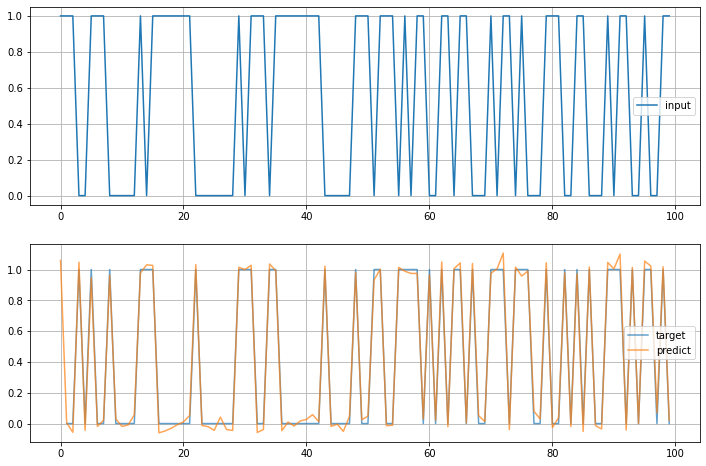

In [39]:
visualize_xor_task(network, num_steps=100)

## 2. 時間的パリティタスク

3ビットパリティ関数：３つの引数の中の１の個数が奇数ならば１，偶数ならば０を返す関数。

$$
d(n) = PAR(u(n-\tau), u(n-\tau-1),u(n-\tau-2))\  (n\leq\tau+3)
$$

少なくとも$\tau+2$ステップ分は覚えていないと解けない

In [8]:
def parity_function(u1, u2, u3):
    """パリティ関数"""
    return (u1 + u2 + u3)%2 

In [9]:
print(parity_function(1, 1, 0) == 0)
print(parity_function(1, 0, 0) == 1)
print(parity_function(1, 1, 1) == 1)
print(parity_function(0, 0, 0) == 0)

True
True
True
True


In [41]:
# ネットワークの定義
d_hidden = 40
network_config = {
    "d_in": 1,
    "d_hidden": d_hidden,
    "d_out": 1,
    "density": 0.1,
    "rho_w": 0.90
}

network = EchoStateNetwork(**network_config)

In [42]:
num_steps = 100
tau = 0  # パリティ関数をなんステップ前から適用するか
input_vectors = np.random.choice([0, 1], size=[num_steps, 1, 1])

desired_output = np.zeros([num_steps, 1, 1])
for i in range(tau+2, num_steps):
    desired_output[i, 0, 0] = parity_function(
        input_vectors[i-tau, 0, 0], input_vectors[i-tau-1, 0, 0], input_vectors[i-tau-2, 0, 0])
desired_output = np.array(desired_output).reshape(-1, 1, 1)

In [46]:
def visualize_parity_task(network, num_steps=1000, tau=4):
    """パリティタスクを解かせた様子を可視化する"""
    input_vectors = np.random.choice([0, 1], size=[num_steps, 1, 1])

    # 教師データの生成。長さ関係でごちゃごちゃしないためにデフォルトで0埋めしておく
    desired_output = np.zeros([num_steps, 1, 1])
    for i in range(tau+2, num_steps):
        desired_output[i, 0, 0] = parity_function(
            input_vectors[i-tau, 0, 0], input_vectors[i-tau-1, 0, 0], input_vectors[i-tau-2, 0, 0])
    desired_output = np.array(desired_output).reshape(-1, 1, 1)
    
    _, predicts_value = network.take_steps(input_vectors,
                                          num_steps=num_steps,
                                          leak_rate=0.0)
    predicts = np.where(predicts_value > 0.5, 1.0, 0.0)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(input_vectors[:, 0, 0], label="input")
    axes[0].legend()
    axes[0].grid()
    
    axes[1].plot(np.arange(num_steps), desired_output[:, 0, 0], label="target", alpha=0.7)
    axes[1].plot(np.arange(num_steps), predicts_value[:, 0, 0], label="predict", alpha=0.7)
    axes[1].legend()
    axes[1].grid()
    
    fig.show()
    
    bit_error_rate = np.where(predicts[:, 0, 0] != desired_output[:, 0, 0], 1, 0).mean()
    print("BER: ", bit_error_rate)

/Users/oharasoh/reservoir/reservoir_demo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


BER:  0.035


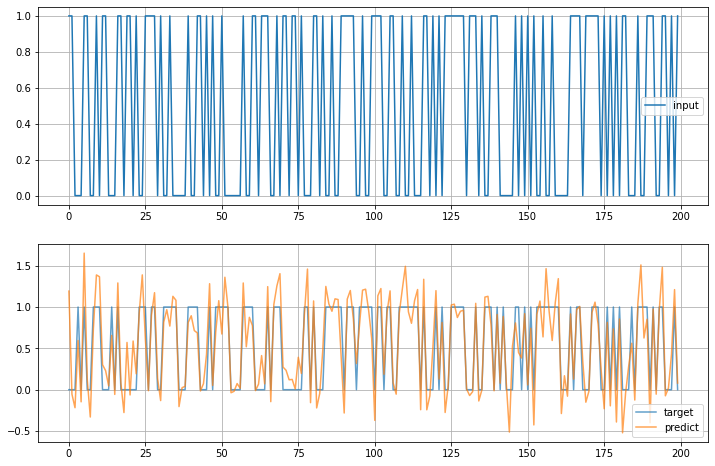

In [50]:
visualize_parity_task(network, num_steps=200, tau=0)

In [48]:
train_network(network,
              input_vectors,
              desired_output,
              start_offset=0,
              end_offset=0,
              train_method="linear",
              ridge_alpha=1e-4)

/Users/oharasoh/reservoir/reservoir_demo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


BER:  0.04


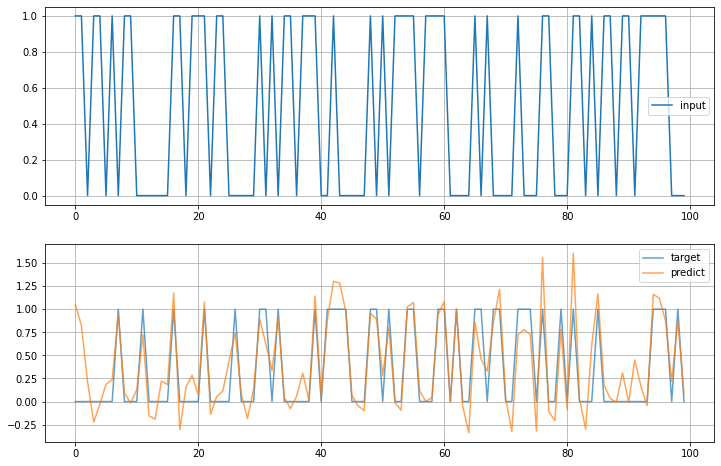

In [49]:
visualize_parity_task(network, num_steps=100, tau=0)

## 非線形チャンネル等化

$d(n)\in\{ -3, -1, 1, 3\}$を入力に取り、
$$
\begin{array}{ccc}
    q(n) & = & 0.08d(n+2) - 0.12d(n+1) + d(n) + 0.18d(n-1) \\
         &   & -0.1d(n-2) + 0.09d(n-3) - 0.05d(n-4) + 0.04d(n-5) \\
         &   & +0.03d(n-6) + 0.01d(n-7)
\end{array}
$$

さらに変換され、

$$
u(n) = q(n) + 0.036q(n)^2 - 0.011q(n)^3 + \nu (n)
$$

### タスクの目標

$u(n)$から時刻$n-2$における信号$d(n-2)$を復元すること。

In [2]:
def generate_nonlinear_channel_target(num_steps=100, stdev_noise=0.3):
    """非線形チャネルの入力と出力のペアを作成する"""
    input_vectors = np.zeros([num_steps, 1, 1])
    target_vectors = np.zeros([num_steps, 1, 1])
    signal = np.random.choice([-3, -1, 1, 3], size=[num_steps])
    
    q_seq = np.zeros([num_steps])
    for i in range(7, num_steps-2):
        q_seq[i] = 0.08 * signal[i+2] - 0.12 * signal[i+1] + signal[i] \
            + 0.18 * signal[i-1] - 0.1* signal[i-2] + 0.09 * signal[i-3] \
            - 0.05 * signal[i-4] + 0.04 * signal[i-5] \
            + 0.03 * signal[i-6] + 0.01 * signal[i-7]
    input_vectors[:, 0, 0] = q_seq + 0.036 * q_seq**2 - 0.011 * q_seq**3 + np.random.randn(num_steps) * stdev_noise
    target_vectors[2:, 0, 0] = signal[:-2]
    return input_vectors, target_vectors

In [26]:
def visualize_nonlinear_channel_task(network, num_steps=1000, stdev_noise=0.3, leak_rate=0.2):
    """非線形チャネル等化問題を解かせた様子を可視化する"""

    # 教師データの生成。長さ関係でごちゃごちゃしないためにデフォルトで0埋めしておく
    input_vectors, desired_output = generate_nonlinear_channel_target(num_steps, stdev_noise)
    
    
    _, predicts_value = network.take_steps(input_vectors,
                                          num_steps=num_steps,
                                          leak_rate=leak_rate)
    predicts_idx = np.abs(predicts_value.reshape([-1, 1]) - np.array([-3, -1, 1, 3])).argmin(axis=1)
    predicts = np.array([-3, -1, 1, 3])[predicts_idx].reshape(-1, 1, 1)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(input_vectors[:, 0, 0], label="input")
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title("Input")
    
    axes[1].plot(np.arange(num_steps), desired_output[:, 0, 0], label="target", alpha=0.7)
    axes[1].plot(np.arange(num_steps), predicts_value[:, 0, 0], label="predict", alpha=0.7)
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title("Output")
    
    fig.tight_layout()
    fig.show()
    
    symbol_error_rate = np.where(predicts[:, 0, 0] != desired_output[:, 0, 0], 1, 0).mean()
    print("SER: ", symbol_error_rate)

In [39]:
# ネットワークの定義
d_hidden = 40
network_config = {
    "d_in": 1,
    "d_hidden": d_hidden,
    "d_out": 1,
    "density": 0.1,
    "rho_w": 0.9
}
leak_rate = 0.05
network = EchoStateNetwork(**network_config)

/Users/oharasoh/reservoir/reservoir_demo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


SER:  0.75


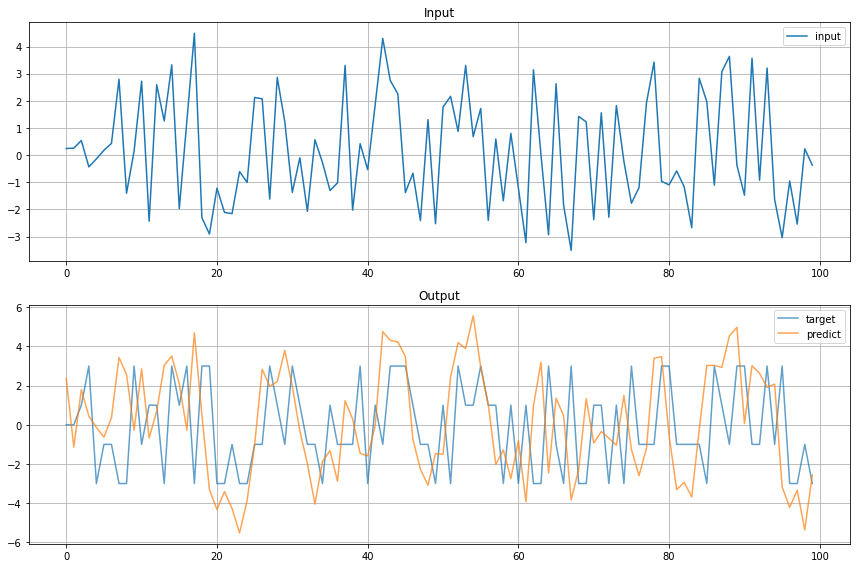

In [40]:
visualize_nonlinear_channel_task(network, num_steps=100, stdev_noise=0.3, leak_rate=leak_rate)

In [41]:
# 教師データの作成およびリードアウト層の訓練
input_vectors, target_vectors = generate_nonlinear_channel_target(num_steps=100, stdev_noise=0.05)
train_network(network,
              input_vectors,
              target_vectors,
              start_offset=0,
              end_offset=0,
              train_method="ridge",
              ridge_alpha=1e-2,
              leak_rate=leak_rate
            )

/Users/oharasoh/reservoir/reservoir_demo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


SER:  0.165


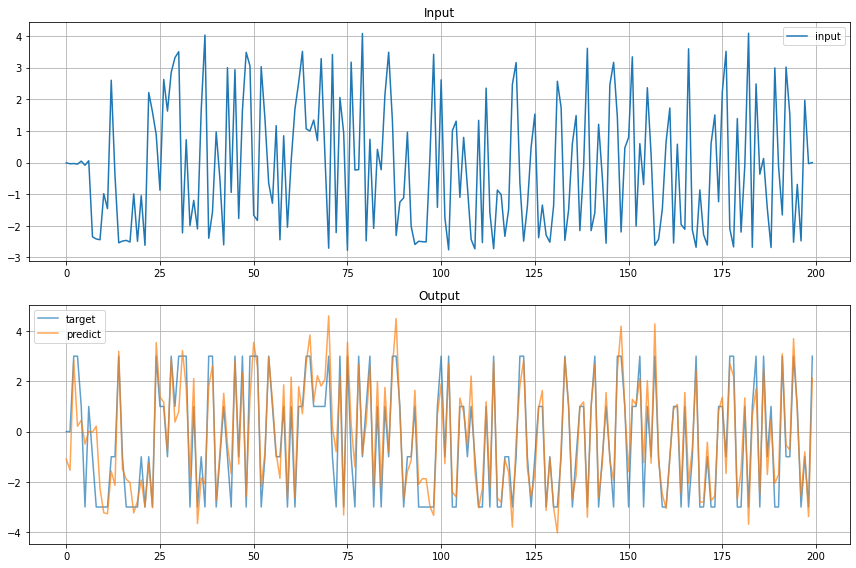

In [42]:
# 訓練結果の確認
visualize_nonlinear_channel_task(network, num_steps=200, stdev_noise=0.05, leak_rate=leak_rate)

## 波形分類タスク

特徴的な形の波形を生成し、その波形を分類する。  
のこぎり波と正弦波とをランダムにつなぎ合わせる。

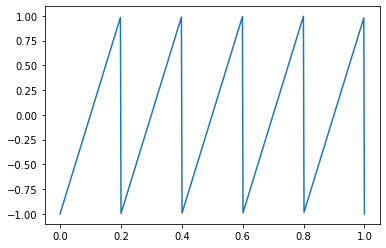

In [46]:
t = np.linspace(0, 1, 500)
plt.plot(t, signal.sawtooth(2 * np.pi * 5 * t))

In [63]:
def generate_waveform(num_steps=500, period_length=50, min_span=50):
    """波形をランダムに生成しそれに合わせて答えのデータも作成する"""
    time_index = 0
    input_vectors = np.zeros([num_steps, 1, 1])
    output_vectors = np.zeros([num_steps, 1, 1])
    signal_type = np.random.randint(2)
    while time_index < num_steps:
        if signal_type == 0:
            waveform_func = np.sin
            offset = 0.0
        else:
            waveform_func = signal.sawtooth
            offset = 1.0 * np.pi
            
        signal_length = np.random.randint(min_span, min_span+100)
        if time_index + signal_length > num_steps:
            signal_length = num_steps - time_index
        t = np.arange(time_index, time_index+signal_length)
        waveform = waveform_func(2.0 * np.pi / period_length * t + offset)
        
        input_vectors[time_index:time_index+signal_length, 0, 0] = waveform
        output_vectors[time_index:time_index+signal_length, 0, 0] = signal_type
        
        time_index += signal_length
        signal_type = (signal_type - 1)**2
    return input_vectors, output_vectors

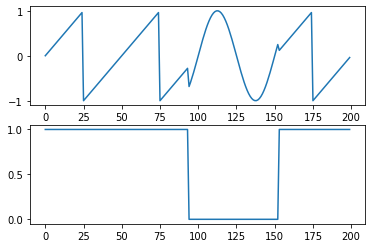

In [65]:
input_vectors, target_vectors = generate_waveform(num_steps=200, period_length=50, min_span=50)


plt.subplot(2, 1, 1)
plt.plot(input_vectors.flatten())

plt.subplot(2, 1, 2)
plt.plot(target_vectors.flatten())

In [73]:
def visualize_wave_classification_task(network, num_steps=1000, period_length=50, min_span=100, leak_rate=0.2):
    """非線形チャネル等化問題を解かせた様子を可視化する"""

    # 教師データの生成。長さ関係でごちゃごちゃしないためにデフォルトで0埋めしておく
    input_vectors, desired_output = generate_waveform(num_steps, period_length, min_span)
    
    
    _, predicts_value = network.take_steps(input_vectors,
                                          num_steps=num_steps,
                                          leak_rate=leak_rate)
    predicts = np.where(predicts_value > 0.5, 1.0, 0.0)
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    axes[0].plot(input_vectors[:, 0, 0], label="input")
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title("Input")
    
    axes[1].plot(np.arange(num_steps), desired_output[:, 0, 0], label="target", alpha=0.7)
    axes[1].plot(np.arange(num_steps), predicts_value[:, 0, 0], label="predict", alpha=0.7)
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title("Output")
    
    fig.tight_layout()
    fig.show()
    
    accuracy = np.where(predicts[:, 0, 0] == desired_output[:, 0, 0], 1, 0).mean()
    print("ACC: ", accuracy)

In [84]:
# ネットワークの定義
d_hidden = 40
network_config = {
    "d_in": 1,
    "d_hidden": d_hidden,
    "d_out": 1,
    "density": 0.1,
    "rho_w": 0.9
}
leak_rate = 0.0
network = EchoStateNetwork(**network_config)

In [85]:
period_length = 10
min_span = 100
# 教師データの作成およびリードアウト層の訓練
input_vectors, target_vectors = generate_waveform(num_steps=1000, period_length=period_length, min_span=min_span)
train_network(network,
              input_vectors,
              target_vectors,
              start_offset=0,
              end_offset=0,
              train_method="linear",
              ridge_alpha=1e-2,
              leak_rate=leak_rate
            )

/Users/oharasoh/reservoir/reservoir_demo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


ACC:  0.988


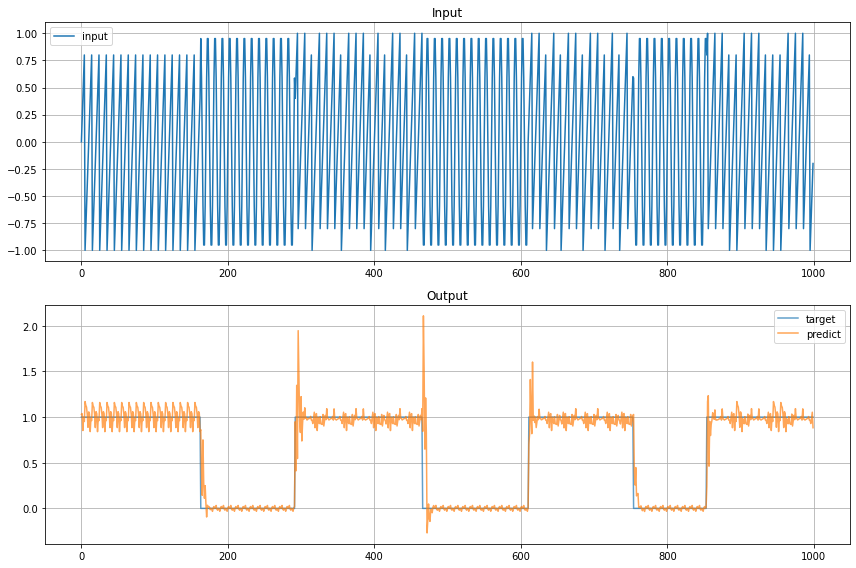

In [86]:
visualize_wave_classification_task(
    network, num_steps=1000, period_length=period_length, min_span=min_span, leak_rate=leak_rate)

## 正弦波生成

入力に応じた周波数を持った正弦波を出力していく